In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:

# Load data

df = pd.read_csv("light_pollution_data.csv")

In [3]:
# Define target and predictors
X = df.drop(columns=["light_pollution", "fid"])
y = df["light_pollution"]

In [4]:
# Column types
numeric_features = [
    "building_volume",
    "population_density",
    "greenhouse_coverage",
    "road_density"
]

categorical_features = ["city"]

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Random Forest model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [5]:
import numpy as np

feature_names = (
    numeric_features +
    list(model.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .named_steps["encoder"]
         .get_feature_names_out(categorical_features))
)

importances = model.named_steps["model"].feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(10)


,feature,importance
2,greenhouse_coverage,0.617169
3,road_density,0.154141
1,population_density,0.146368
0,building_volume,0.080520
4,city_Amsterdam,0.000968
5,city_Den Haag,0.000834


In [6]:
train = df[df["city"] == "Amsterdam"]
test = df[df["city"] == "Den Haag"]

X_train = train.drop(columns=["light_pollution", "fid"])
y_train = train["light_pollution"]

X_test = test.drop(columns=["light_pollution", "fid"])
y_test = test["light_pollution"]


In [7]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [8]:
y_pred = model.predict(X_test)


In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² (city-wise): {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


R² (city-wise): 0.056
MAE: 391.09
RMSE: 1740.41


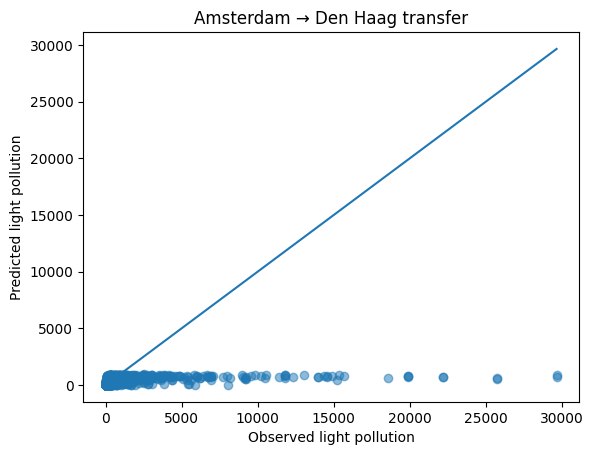

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Observed light pollution")
plt.ylabel("Predicted light pollution")
plt.title("Amsterdam → Den Haag transfer")
plt.show()


In [11]:
# Train on Den Haag, test on Amsterdam
model.fit(X_test, y_test)
y_pred_rev = model.predict(X_train)

print("Reverse R²:",
      r2_score(y_train, y_pred_rev))


Reverse R²: -0.23983970952056954


In [12]:
import shap
rf_model = model.named_steps["model"]




c:\Users\Osaro\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
X_train_transformed = model.named_steps["preprocessor"].transform(X_train)
X_test_transformed  = model.named_steps["preprocessor"].transform(X_test)


In [14]:
feature_names = (
    model.named_steps["preprocessor"]
    .get_feature_names_out()
)


In [15]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed)


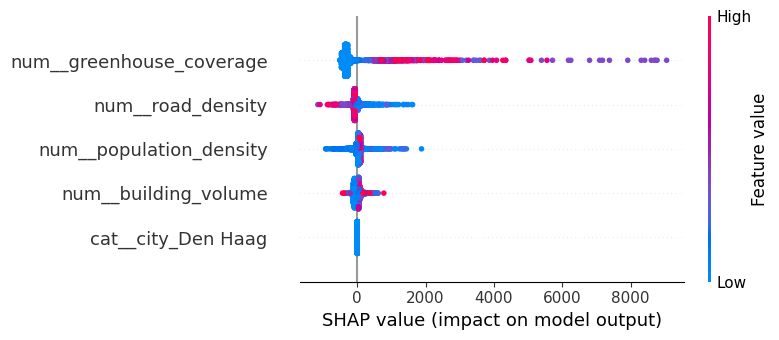

In [20]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names
)


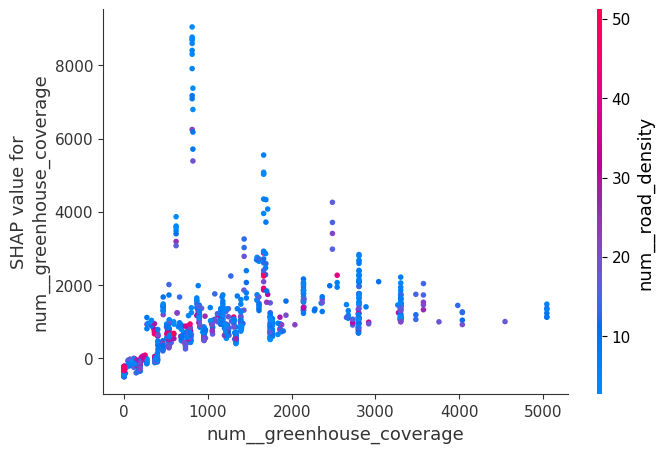

In [22]:
shap.dependence_plot(
    "num__greenhouse_coverage",
    shap_values,
    X_test_transformed,
    feature_names=feature_names
)



NameError: name 'preprocessor_no_gh' is not defined